# Fitting to an electronic friction spectrum

## Objective

The calculation of the electronic friction spectrum is discussed, in detail, in [PRL **134**, 226201 (2025)](https://doi.org/10.1103/PhysRevLett.134.226201). Extensive benchmarking has shown that the ab initio electronic friction kernel gives converged non-Markovian rates in the low friction regime when damped by an exponential window with a decay width of ωc = 4000 cm<sup>-1</sup>. We will be fitting the embedding parameters to this damped spectrum, plotted below

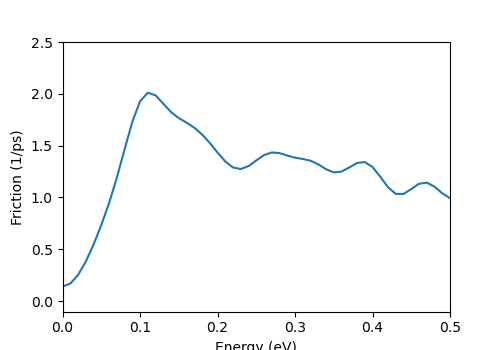

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib widget

friction_spectrum = Path("fixtures")/"target_spectrum.csv"
energy, damped_spectrum = np.loadtxt(friction_spectrum, delimiter=",", unpack=True)
fig, ax = plt.subplots(figsize=(5,3.5))
ax.plot(energy, damped_spectrum)
ax.set_xlim(0, 0.5)
ax.set_ylim(-0.1, 2.5)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Friction (1/ps)");
fig.set_label("Friction spectrum for H/Cu(111)")

Let us set up an example calculation from start to finish. First, we load the input file template, which specifies the objective function, the numerical data for fitting, the types of embedders used and the optimization algorithm + convergence parameters.

In [2]:
import json
with open(Path("fixtures")/"spectrum_optimization_config_template.json") as f:
    config_template = json.load(f)
print(json.dumps(config_template, indent=2))

{
  "data": {
    "spectrum": {
      "source": "external",
      "path": "../../../fixtures/target_spectrum.csv",
      "format": "csv",
      "columns": [
        0,
        1
      ],
      "delimiter": ","
    }
  },
  "merit_function": {
    "type": "spectrum",
    "parameters": {
      "data": "spectrum",
      "metric": "squared"
    }
  },
  "embedder": {
    "type": "multi",
    "parameters": {
      "embedders": []
    }
  },
  "optimization": {
    "type": "EF",
    "parameters": {
      "trajfile": "trajectory.out",
      "logfile": "log.out"
    },
    "options": {
      "max_iter": 100,
      "max_step": 0.2,
      "gtol": 0.01
    }
  }
}


Next, we will optimize the embedding for a direct sum of three "general" 2-by-2 embedders. The initial values are estimated by first decomposing the spectrum into a sum of delta functions (same number as the number of embedders), following the standard "harmonic bath" discretization procedure described by [Walters, Allen, and Makri](https://doi.org/10.1002/jcc.24527).

In [3]:
from glefit.utils.bath import WAM_discretization
max_energy = 1.0 # eV, fitted energy range
naux = 3
embedder = 'gen2x2'
weight, bath_freqs = WAM_discretization(energy, damped_spectrum, naux, wmax=max_energy)

The delta functions are broadened into Lorentzians, with the widths (`gammas`) determined from the spacing between the harmonic bath frequecies.

In [4]:
import copy
import yaml
from glefit.embedding import TwoAuxEmbedder
optimization_workspace: Path = Path("spectrum_optimization") / embedder / f"naux_{naux:02d}"
optimization_workspace.mkdir(exist_ok=True, parents=True)
config_file: Path = optimization_workspace / "config.yaml"
config: dict = copy.deepcopy(config_template)
multi: dict = config['embedder']['parameters']['embedders']
gammas = np.diff(bath_freqs)
gammas = np.concatenate(([gammas[0]], gammas))
for omega, gamma in zip(bath_freqs, gammas):
    EmbClass = TwoAuxEmbedder
    emb_params =  EmbClass.from_harmonic(weight, omega, gamma)
    multi.append({
        'type' : embedder,
        'parameters' : emb_params})        
    emb_params.update({
        'sigma': 50.0,
        'threshold': 10.0})
    with open(config_file, 'w') as f:
        yaml.dump(config, f)